 # Mini-Projeto de Clusterização Não Supervisionada - Dataset Titanic (kaggle)



 **Objetivo:** Comparar os algoritmos K-Means e K-Prototypes para segmentação de passageiros do Titanic,

 analisando qual método oferece clusters mais interpretáveis quando trabalhamos com dados mistos

 (numéricos e categóricos).



 **Dataset:** Titanic (sem o rótulo 'Survived' - análise não supervisionada)



 **Algoritmos:**

 - K-Means (requer One-Hot Encoding)

 - K-Prototypes (lida nativamente com dados categóricos)

 ## 1. Configuração e Importação de Bibliotecas

In [29]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuração visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Machine Learning - Pré-processamento
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Machine Learning - Clustering
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

# Machine Learning - Interpretabilidade
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Utilidades
from collections import Counter
import os

# Criando diretórios para salvar imagens
os.makedirs('results/figures/eda', exist_ok=True)
os.makedirs('results/figures/elbow_plots', exist_ok=True)
os.makedirs('results/figures/clusters', exist_ok=True)
os.makedirs('results/figures/trees', exist_ok=True)

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


 ## 2. Carregamento e Exploração Inicial dos Dados

In [30]:
# Carregando o dataset - tentando múltiplos caminhos
import os

# Lista de caminhos possíveis
possible_paths = [
    ('data/raw/train.csv', 'data/raw/test.csv'),  # Estrutura recomendada
    ('data/train.csv', 'data/test.csv'),          # Pasta data/
    ('train.csv', 'test.csv'),                     # Pasta raiz
    ('../data/raw/train.csv', '../data/raw/test.csv'),  # Se estiver em notebooks/
    ('../data/train.csv', '../data/test.csv'),          # Se estiver em notebooks/
]

df_train = None
df_test = None

print("Procurando os arquivos CSV...")
print(f"Diretório atual: {os.getcwd()}\n")

for train_path, test_path in possible_paths:
    try:
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)
        print(f"✅ Datasets carregados com sucesso!")
        print(f"   📂 Train: {train_path}")
        print(f"   📂 Test: {test_path}")
        print(f"   📊 Train shape: {df_train.shape}")
        print(f"   📊 Test shape: {df_test.shape}")
        break
    except FileNotFoundError:
        continue

if df_train is None or df_test is None:
    print("❌ ERRO: Arquivos train.csv e test.csv não encontrados!")
    print("\n📋 Caminhos tentados:")
    for train_path, test_path in possible_paths:
        print(f"   • {train_path}")
    print("\n💡 Soluções:")
    print("   1. Coloque os arquivos em: data/raw/train.csv e data/raw/test.csv")
    print("   2. Ou coloque na pasta raiz do projeto")
    print(f"   3. Seu diretório atual é: {os.getcwd()}")
    raise FileNotFoundError("Arquivos CSV não encontrados em nenhum caminho conhecido")

# Usando apenas o train.csv (maior volume de dados)
df = df_train.copy()

# Visualização inicial
print("Primeiras linhas do dataset:")
display(df.head(10))

print("\nEstatísticas descritivas:")
display(df.describe())

print("\nValores nulos por coluna:")
null_df = pd.DataFrame({
    'Coluna': df.columns,
    'Nulos': df.isnull().sum().values,
    'Percentual': (df.isnull().sum().values / len(df) * 100).round(2)
})
display(null_df[null_df['Nulos'] > 0])

print(f"\nShape do dataset: {df.shape}")
print(f"Colunas disponíveis: {df.columns.tolist()}")


Procurando os arquivos CSV...
Diretório atual: c:\titanic-clustering-comparison\notebooks

✅ Datasets carregados com sucesso!
   📂 Train: ../data/raw/train.csv
   📂 Test: ../data/raw/test.csv
   📊 Train shape: (891, 12)
   📊 Test shape: (418, 11)
Primeiras linhas do dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C



Estatísticas descritivas:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Valores nulos por coluna:


,Coluna,Nulos,Percentual
5,Age,177,19.87
10,Cabin,687,77.10
11,Embarked,2,0.22



Shape do dataset: (891, 12)
Colunas disponíveis: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


 ## 3. Limpeza e Pré-processamento Inicial

In [31]:
print("=" * 80)
print("ETAPA DE LIMPEZA E PRÉ-PROCESSAMENTO")
print("=" * 80)

# IMPORTANTE: Removendo a coluna alvo (análise não supervisionada)
if 'Survived' in df.columns:
    df = df.drop('Survived', axis=1)
    print("✅ Coluna 'Survived' removida (análise não supervisionada)")

# Removendo colunas com alta cardinalidade, identificadores ou muitos nulos
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop)
print(f"✅ Colunas removidas: {cols_to_drop}")

# Definindo colunas numéricas e categóricas do Titanic
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Verificando se todas existem
numeric_cols = [col for col in numeric_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Criando dataset de trabalho
selected_cols = numeric_cols + categorical_cols
df_work = df[selected_cols].copy()

print(f"\n📊 Colunas numéricas selecionadas: {numeric_cols}")
print(f"📊 Colunas categóricas selecionadas: {categorical_cols}")
print(f"\n📏 Shape após seleção: {df_work.shape}")


ETAPA DE LIMPEZA E PRÉ-PROCESSAMENTO
✅ Coluna 'Survived' removida (análise não supervisionada)
✅ Colunas removidas: ['PassengerId', 'Name', 'Ticket', 'Cabin']

📊 Colunas numéricas selecionadas: ['Age', 'Fare', 'SibSp', 'Parch']
📊 Colunas categóricas selecionadas: ['Pclass', 'Sex', 'Embarked']

📏 Shape após seleção: (891, 7)


 ## 4. Tratamento de Valores Nulos

In [32]:
print("=" * 70)
print("TRATAMENTO DE VALORES NULOS")
print("=" * 70)

print("\nValores nulos ANTES do tratamento:")
null_before = df_work.isnull().sum()
null_before_df = pd.DataFrame({
    'Coluna': null_before.index,
    'Nulos': null_before.values,
    'Percentual': (null_before.values / len(df_work) * 100).round(2)
})
display(null_before_df[null_before_df['Nulos'] > 0])

# Imputação de medianas (numéricas) e modas (categóricas)

imputation_log = []
for col in numeric_cols:
    if df_work[col].isnull().sum() > 0:
        median_val = df_work[col].median()
        nulls_filled = df_work[col].isnull().sum()
        df_work[col].fillna(median_val, inplace=True)
        imputation_log.append({
            'Coluna': col,
            'Tipo': 'Numérica',
            'Método': 'Mediana',
            'Valor': f"{median_val:.2f}",
            'Nulos_Preenchidos': nulls_filled
        })

for col in categorical_cols:
    if df_work[col].isnull().sum() > 0:
        mode_val = df_work[col].mode()[0]
        nulls_filled = df_work[col].isnull().sum()
        df_work[col].fillna(mode_val, inplace=True)
        imputation_log.append({
            'Coluna': col,
            'Tipo': 'Categórica',
            'Método': 'Moda',
            'Valor': str(mode_val),
            'Nulos_Preenchidos': nulls_filled
        })

if imputation_log:
    print("\nImputação realizada:")
    display(pd.DataFrame(imputation_log))

#print(f"\Shape final: {df_work.shape}")
#print(f"✅ Dataset limpo e pronto para análise!")


TRATAMENTO DE VALORES NULOS

Valores nulos ANTES do tratamento:


,Coluna,Nulos,Percentual
0,Age,177,19.87
6,Embarked,2,0.22



Imputação realizada:


,Coluna,Tipo,Método,Valor,Nulos_Preenchidos
0,Age,Numérica,Mediana,28.00,177
1,Embarked,Categórica,Moda,S,2


 ## 5. Análise Exploratória de Dados (EDA)

In [33]:
print("=" * 70)
print("ANÁLISE EXPLORATÓRIA DE DADOS")
print("=" * 70)

# Estatísticas básicas por variável
print("\n📊 Estatísticas das Variáveis Numéricas:")
print(df_work[numeric_cols].describe())

print("\nDistribuição das Variáveis Categóricas:")
cat_stats = []
for col in categorical_cols:
    value_counts = df_work[col].value_counts()
    for value, count in value_counts.items():
        cat_stats.append({
            'Variável': col,
            'Categoria': value,
            'Contagem': count,
            'Percentual': f"{(count/len(df_work)*100):.2f}%"
        })
display(pd.DataFrame(cat_stats))


ANÁLISE EXPLORATÓRIA DE DADOS

📊 Estatísticas das Variáveis Numéricas:
              Age        Fare       SibSp       Parch
count  891.000000  891.000000  891.000000  891.000000
mean    29.361582   32.204208    0.523008    0.381594
std     13.019697   49.693429    1.102743    0.806057
min      0.420000    0.000000    0.000000    0.000000
25%     22.000000    7.910400    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     35.000000   31.000000    1.000000    0.000000
max     80.000000  512.329200    8.000000    6.000000

Distribuição das Variáveis Categóricas:


,Variável,Categoria,Contagem,Percentual
0,Pclass,3,491,55.11%
1,Pclass,1,216,24.24%
2,Pclass,2,184,20.65%
3,Sex,male,577,64.76%
4,Sex,female,314,35.24%
5,Embarked,S,646,72.50%
6,Embarked,C,168,18.86%
7,Embarked,Q,77,8.64%


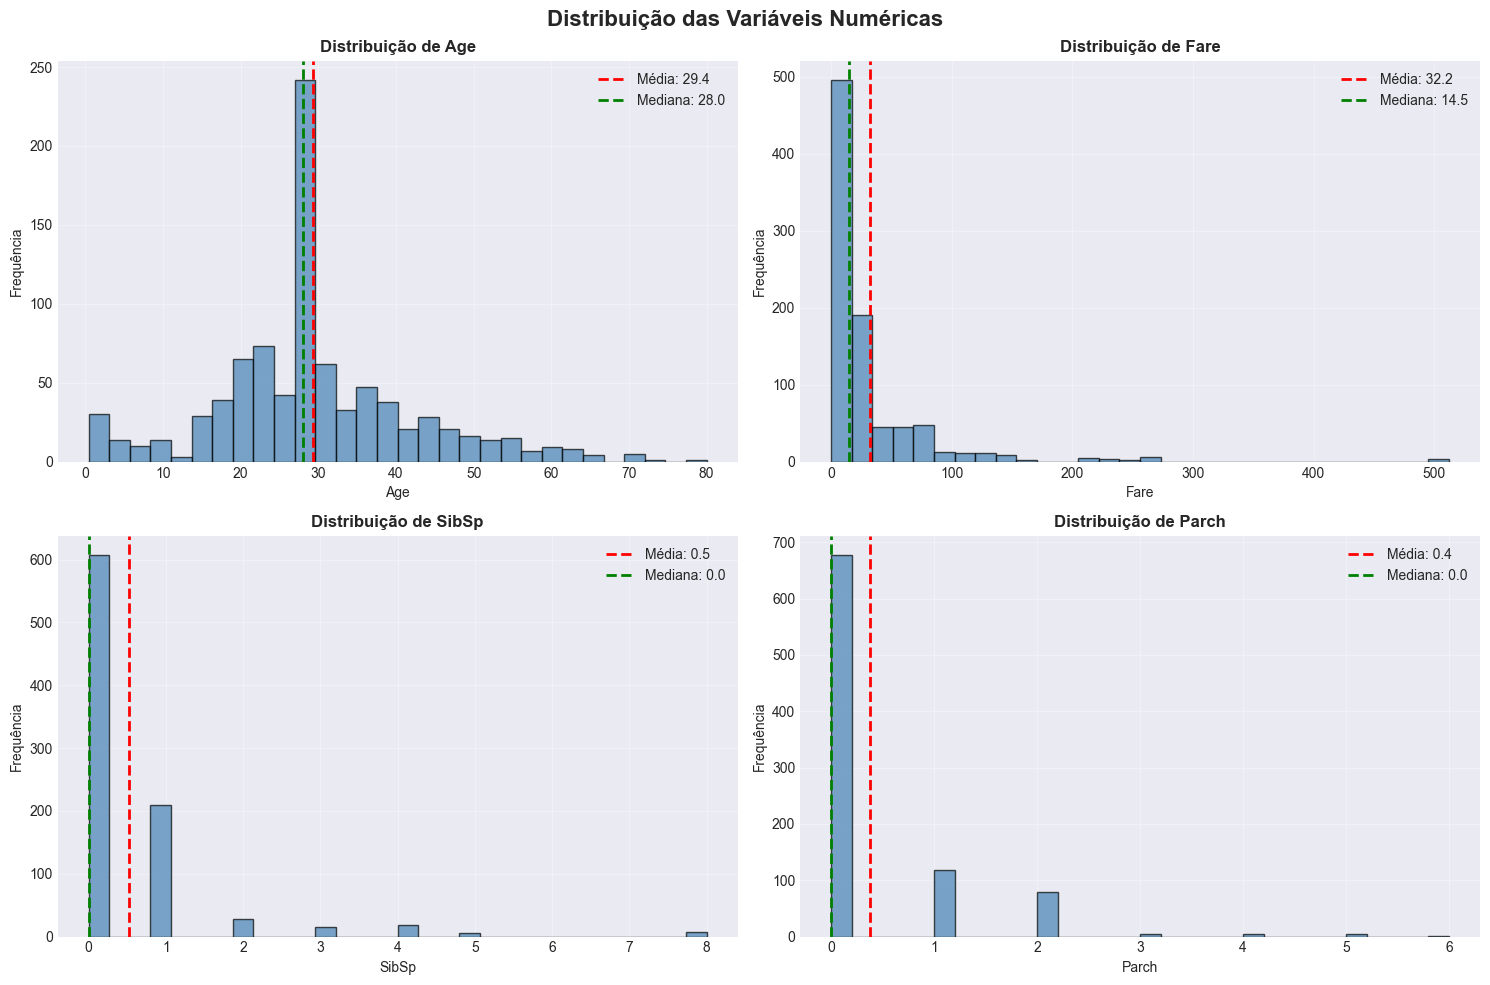

Figura salva em: results/figures/eda/distribuicao_numericas.png


In [34]:
# Visualização de distribuições - Variáveis numéricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribuição das Variáveis Numéricas', fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_idx = idx % 2
    
    axes[row, col_idx].hist(df_work[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[row, col_idx].set_title(f'Distribuição de {col}', fontweight='bold', fontsize=12)
    axes[row, col_idx].set_xlabel(col, fontsize=10)
    axes[row, col_idx].set_ylabel('Frequência', fontsize=10)
    axes[row, col_idx].grid(True, alpha=0.3)
    
    # Adicionando estatísticas
    mean_val = df_work[col].mean()
    median_val = df_work[col].median()
    axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.1f}')
    axes[row, col_idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.1f}')
    axes[row, col_idx].legend()

plt.tight_layout()
plt.savefig('results/figures/eda/distribuicao_numericas.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/eda/distribuicao_numericas.png")


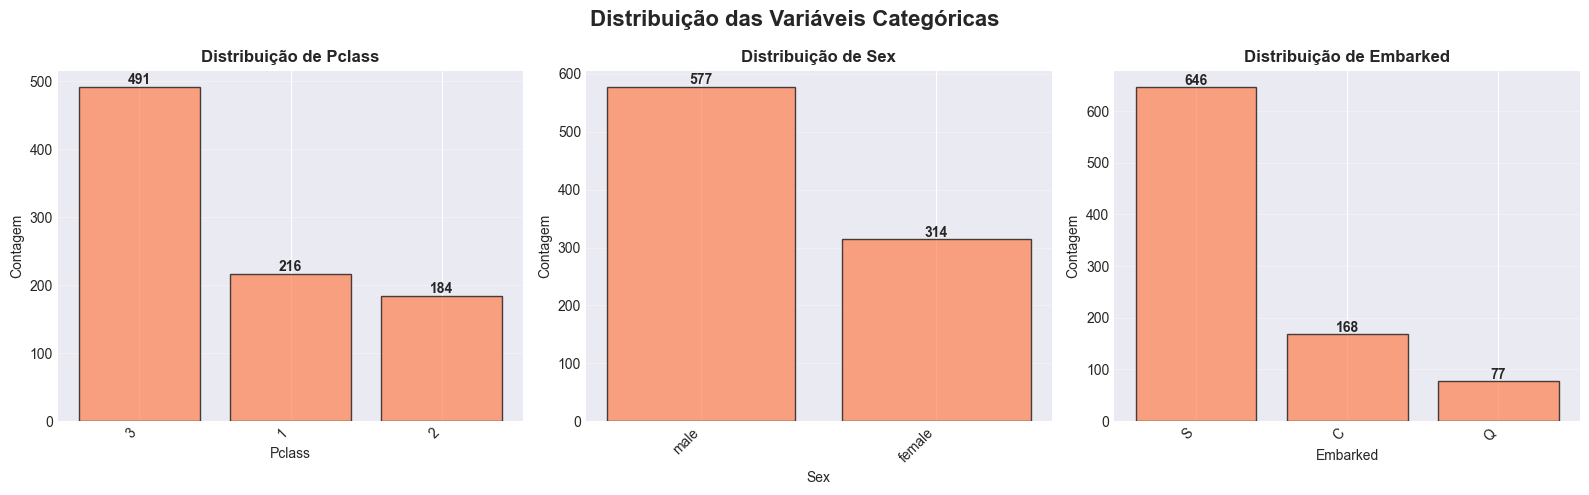

Figura salva em: results/figures/eda/distribuicao_categoricas.png


In [35]:
# Visualização de distribuições - Variáveis categóricas
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Distribuição das Variáveis Categóricas', fontsize=16, fontweight='bold')

for idx, col in enumerate(categorical_cols):
    value_counts = df_work[col].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values, 
                  edgecolor='black', alpha=0.7, color='coral')
    axes[idx].set_title(f'Distribuição de {col}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Contagem', fontsize=10)
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Adicionando valores no topo das barras
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/eda/distribuicao_categoricas.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/eda/distribuicao_categoricas.png")


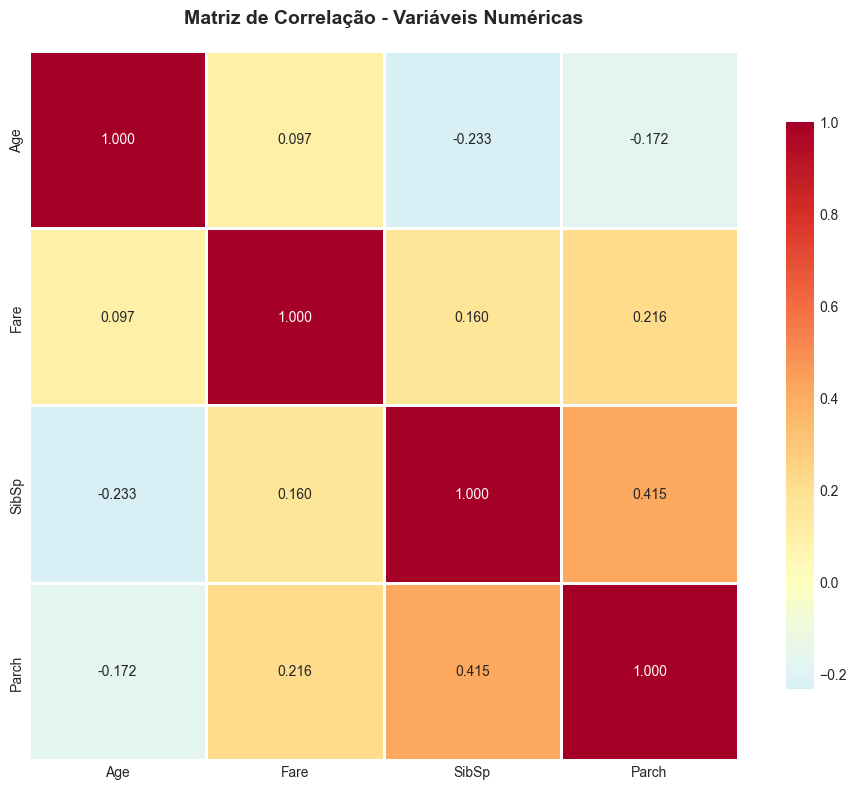


💡 Insights da Correlação:
   • SibSp e Parch têm correlação positiva (famílias maiores)
   • Age e Fare têm correlação fraca
   • Variáveis são relativamente independentes
Figura salva em: results/figures/eda/matriz_correlacao.png


In [36]:
# Matriz de correlação entre variáveis numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df_work[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=2, fmt='.3f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('results/figures/eda/matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Insights da Correlação:")
print("   • SibSp e Parch têm correlação positiva (famílias maiores)")
print("   • Age e Fare têm correlação fraca")
print("   • Variáveis são relativamente independentes")
print("Figura salva em: results/figures/eda/matriz_correlacao.png")


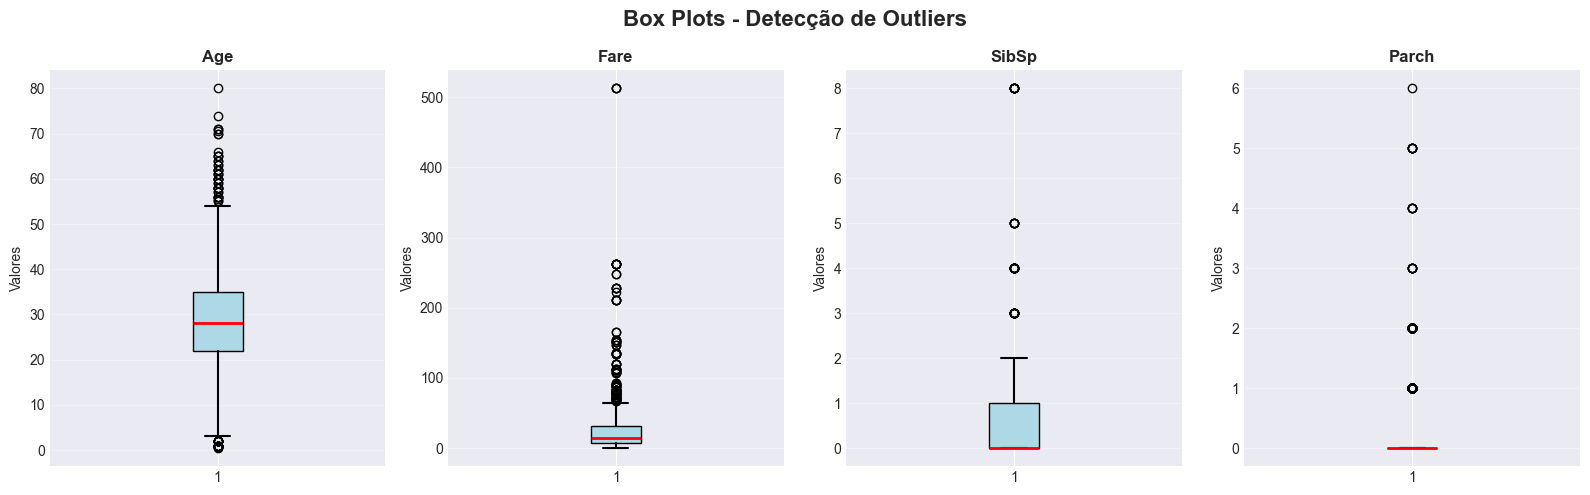

Figura salva em: results/figures/eda/boxplots_outliers.png


In [37]:
# Box plots para detectar outliers
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle('Box Plots - Detecção de Outliers', fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df_work[col].dropna(), vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='black', linewidth=1.5),
                      capprops=dict(color='black', linewidth=1.5))
    axes[idx].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Valores', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/eda/boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/eda/boxplots_outliers.png")


 ## 6. Pré-processamento para K-Means (Fluxo A)

In [38]:
print("=" * 70)
print("FLUXO A: PRÉ-PROCESSAMENTO PARA K-MEANS")
print("=" * 70)

# K-Means requer TODOS os dados em formato numérico
# Estratégia: StandardScaler + One-Hot Encoding

df_kmeans = df_work.copy()

print("\n1️⃣ Normalizando variáveis numéricas...")
# Normalização das numéricas (média=0, desvio=1)
scaler_kmeans = StandardScaler()
df_kmeans[numeric_cols] = scaler_kmeans.fit_transform(df_kmeans[numeric_cols])
print(f"   ✅ Variáveis normalizadas: {numeric_cols}")

print("\n2️⃣ Aplicando One-Hot Encoding nas categóricas...")
# One-Hot Encoding nas categóricas (cria colunas binárias)
df_kmeans = pd.get_dummies(df_kmeans, columns=categorical_cols, drop_first=True)
print(f"   ✅ One-Hot Encoding aplicado")
print(f"   📏 Shape ANTES: {df_work.shape}")
print(f"   📏 Shape DEPOIS: {df_kmeans.shape}")
print(f"   📈 Aumento de dimensionalidade: {df_kmeans.shape[1] - len(numeric_cols)} novas features")

print(f"\n📋 Colunas finais (total={len(df_kmeans.columns)}):")
for i, col in enumerate(df_kmeans.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n✅ Dataset preparado para K-Means!")


FLUXO A: PRÉ-PROCESSAMENTO PARA K-MEANS

1️⃣ Normalizando variáveis numéricas...
   ✅ Variáveis normalizadas: ['Age', 'Fare', 'SibSp', 'Parch']

2️⃣ Aplicando One-Hot Encoding nas categóricas...
   ✅ One-Hot Encoding aplicado
   📏 Shape ANTES: (891, 7)
   📏 Shape DEPOIS: (891, 9)
   📈 Aumento de dimensionalidade: 5 novas features

📋 Colunas finais (total=9):
    1. Age
    2. Fare
    3. SibSp
    4. Parch
    5. Pclass_2
    6. Pclass_3
    7. Sex_male
    8. Embarked_Q
    9. Embarked_S

✅ Dataset preparado para K-Means!


 ## 7. Pré-processamento para K-Prototypes (Fluxo B)

In [39]:
print("=" * 70)
print("FLUXO B: PRÉ-PROCESSAMENTO PARA K-PROTOTYPES")
print("=" * 70)

# K-Prototypes trabalha nativamente com dados MISTOS
# Estratégia: Normalizar apenas numéricas + Manter categóricas

df_kproto = df_work.copy()

print("\n1️⃣ Normalizando variáveis numéricas...")
# Normalização das numéricas
scaler_kproto = StandardScaler()
df_kproto[numeric_cols] = scaler_kproto.fit_transform(df_kproto[numeric_cols])
print(f"   ✅ Variáveis normalizadas: {numeric_cols}")

print("\n2️⃣ Convertendo categóricas para códigos numéricos...")
# Converter categóricas para códigos (necessário para biblioteca kmodes)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_kproto[col] = le.fit_transform(df_kproto[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ {col}: {list(le.classes_)}")

print("\n3️⃣ Identificando índices das colunas categóricas...")
# K-Prototypes precisa saber quais colunas são categóricas
categorical_indices = [df_kproto.columns.get_loc(col) for col in categorical_cols]
print(f"   ✅ Índices das colunas categóricas: {categorical_indices}")
print(f"   📋 Mapeamento: {dict(zip(categorical_cols, categorical_indices))}")

print(f"\n📏 Shape final: {df_kproto.shape}")
print(f"📋 Estrutura preservada (sem aumento de dimensionalidade)")
print("\n✅ Dataset preparado para K-Prototypes!")


FLUXO B: PRÉ-PROCESSAMENTO PARA K-PROTOTYPES

1️⃣ Normalizando variáveis numéricas...
   ✅ Variáveis normalizadas: ['Age', 'Fare', 'SibSp', 'Parch']

2️⃣ Convertendo categóricas para códigos numéricos...
   ✅ Pclass: ['1', '2', '3']
   ✅ Sex: ['female', 'male']
   ✅ Embarked: ['C', 'Q', 'S']

3️⃣ Identificando índices das colunas categóricas...
   ✅ Índices das colunas categóricas: [4, 5, 6]
   📋 Mapeamento: {'Pclass': 4, 'Sex': 5, 'Embarked': 6}

📏 Shape final: (891, 7)
📋 Estrutura preservada (sem aumento de dimensionalidade)

✅ Dataset preparado para K-Prototypes!


 ## 8. Método do Cotovelo (Elbow Method) - K-Means

In [40]:
print("=" * 90)
print("OTIMIZAÇÃO DO NÚMERO DE CLUSTERS - K-MEANS")
print("=" * 90)

k_range = range(2, 11)
inertias_kmeans = []
silhouette_scores_kmeans = []
davies_bouldin_scores_kmeans = []
calinski_harabasz_scores_kmeans = []

print("\n🔄 Testando diferentes valores de k...\n")

results_km = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(df_kmeans)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(df_kmeans, labels)
    davies_bouldin = davies_bouldin_score(df_kmeans, labels)
    calinski_harabasz = calinski_harabasz_score(df_kmeans, labels)
    
    inertias_kmeans.append(inertia)
    silhouette_scores_kmeans.append(silhouette)
    davies_bouldin_scores_kmeans.append(davies_bouldin)
    calinski_harabasz_scores_kmeans.append(calinski_harabasz)
    
    results_km.append({
        'k': k,
        'Inertia': f"{inertia:.2f}",
        'Silhouette': f"{silhouette:.3f}",
        'Davies-Bouldin': f"{davies_bouldin:.3f}",
        'Calinski-Harabasz': f"{calinski_harabasz:.2f}"
    })

display(pd.DataFrame(results_km))


OTIMIZAÇÃO DO NÚMERO DE CLUSTERS - K-MEANS

🔄 Testando diferentes valores de k...



,k,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,3347.00,0.436,1.496,274.84
1,3,2821.58,0.312,1.456,245.50
2,4,2412.72,0.280,1.298,241.29
3,5,2044.56,0.298,1.225,253.20
4,6,1837.34,0.261,1.331,245.12
5,7,1678.70,0.265,1.307,237.24
6,8,1539.64,0.265,1.193,232.85
7,9,1436.21,0.271,1.170,226.11
8,10,1358.96,0.281,1.161,217.74


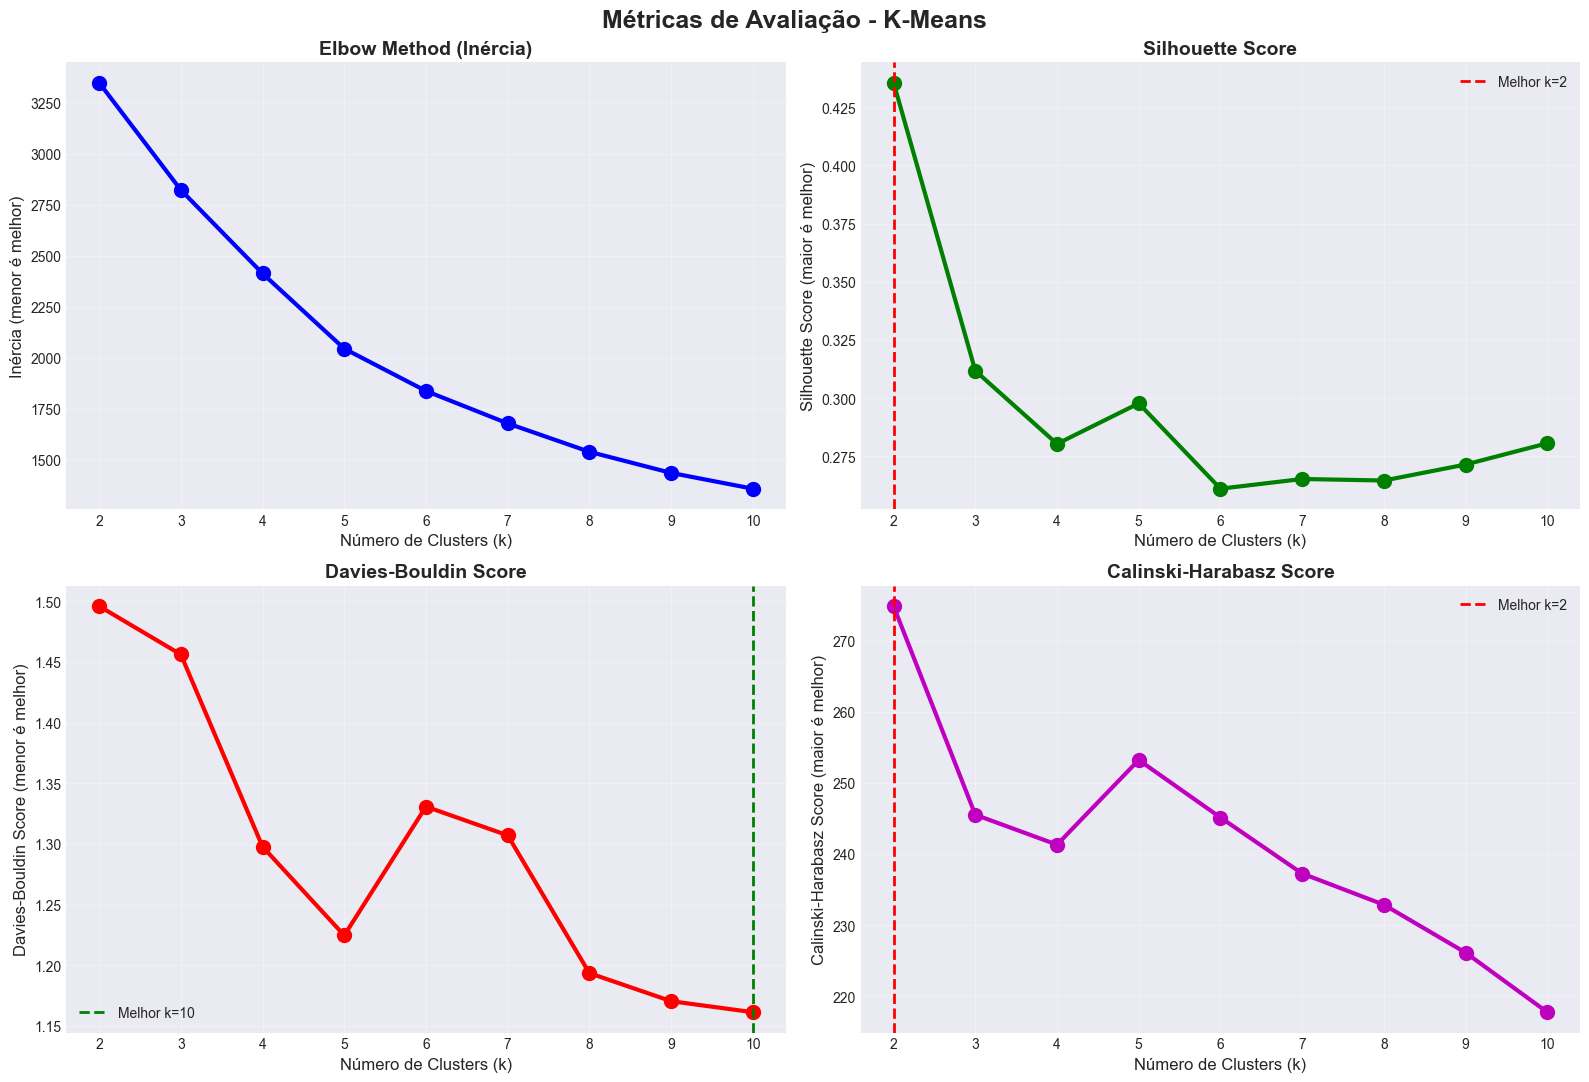

Figura salva em: results/figures/elbow_plots/kmeans_metricas.png

🎯 Sugestões de k baseadas nas métricas:
   • Silhouette Score: k = 2
   • Davies-Bouldin: k = 10
   • Calinski-Harabasz: k = 2


In [41]:
# Visualização das métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Métricas de Avaliação - K-Means', fontsize=18, fontweight='bold')

# 1. Elbow Method (Inércia)
axes[0, 0].plot(k_range, inertias_kmeans, 'bo-', linewidth=3, markersize=10)
axes[0, 0].set_title('Elbow Method (Inércia)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inércia (menor é melhor)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores_kmeans, 'go-', linewidth=3, markersize=10)
axes[0, 1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score (maior é melhor)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
best_k_sil = k_range[np.argmax(silhouette_scores_kmeans)]
axes[0, 1].axvline(best_k_sil, color='red', linestyle='--', linewidth=2, label=f'Melhor k={best_k_sil}')
axes[0, 1].legend()

# 3. Davies-Bouldin Score
axes[1, 0].plot(k_range, davies_bouldin_scores_kmeans, 'ro-', linewidth=3, markersize=10)
axes[1, 0].set_title('Davies-Bouldin Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score (menor é melhor)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_range)
best_k_db = k_range[np.argmin(davies_bouldin_scores_kmeans)]
axes[1, 0].axvline(best_k_db, color='green', linestyle='--', linewidth=2, label=f'Melhor k={best_k_db}')
axes[1, 0].legend()

# 4. Calinski-Harabasz Score
axes[1, 1].plot(k_range, calinski_harabasz_scores_kmeans, 'mo-', linewidth=3, markersize=10)
axes[1, 1].set_title('Calinski-Harabasz Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score (maior é melhor)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_range)
best_k_ch = k_range[np.argmax(calinski_harabasz_scores_kmeans)]
axes[1, 1].axvline(best_k_ch, color='red', linestyle='--', linewidth=2, label=f'Melhor k={best_k_ch}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('results/figures/elbow_plots/kmeans_metricas.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/elbow_plots/kmeans_metricas.png")

print(f"\n🎯 Sugestões de k baseadas nas métricas:")
print(f"   • Silhouette Score: k = {best_k_sil}")
print(f"   • Davies-Bouldin: k = {best_k_db}")
print(f"   • Calinski-Harabasz: k = {best_k_ch}")


 ## 9. Método do Cotovelo (Elbow Method) - K-Prototypes

In [42]:
print("=" * 75)
print("OTIMIZAÇÃO DO NÚMERO DE CLUSTERS - K-PROTOTYPES")
print("=" * 75)

k_range = range(2, 11)
costs_kproto = []
silhouette_scores_kproto = []

print("\n🔄 Testando diferentes valores de k...\n")
print("⚠️ K-Prototypes pode demorar mais (lida com dados categóricos nativamente)\n")

results_kp = []
for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42, verbose=0, max_iter=100)
    labels = kproto.fit_predict(df_kproto.values, categorical=categorical_indices)
    
    cost = kproto.cost_
    silhouette = silhouette_score(df_kproto, labels)
    
    costs_kproto.append(cost)
    silhouette_scores_kproto.append(silhouette)
    
    results_kp.append({
        'k': k,
        'Cost': f"{cost:.2f}",
        'Silhouette': f"{silhouette:.3f}"
    })

display(pd.DataFrame(results_kp))


OTIMIZAÇÃO DO NÚMERO DE CLUSTERS - K-PROTOTYPES

🔄 Testando diferentes valores de k...

⚠️ K-Prototypes pode demorar mais (lida com dados categóricos nativamente)



,k,Cost,Silhouette
0,2,3006.18,0.411
1,3,2479.22,0.321
2,4,2070.95,0.283
3,5,1712.87,0.293
4,6,1542.69,0.297
5,7,1395.47,0.301
6,8,1299.86,0.305
7,9,1219.94,0.222
8,10,1141.64,0.223


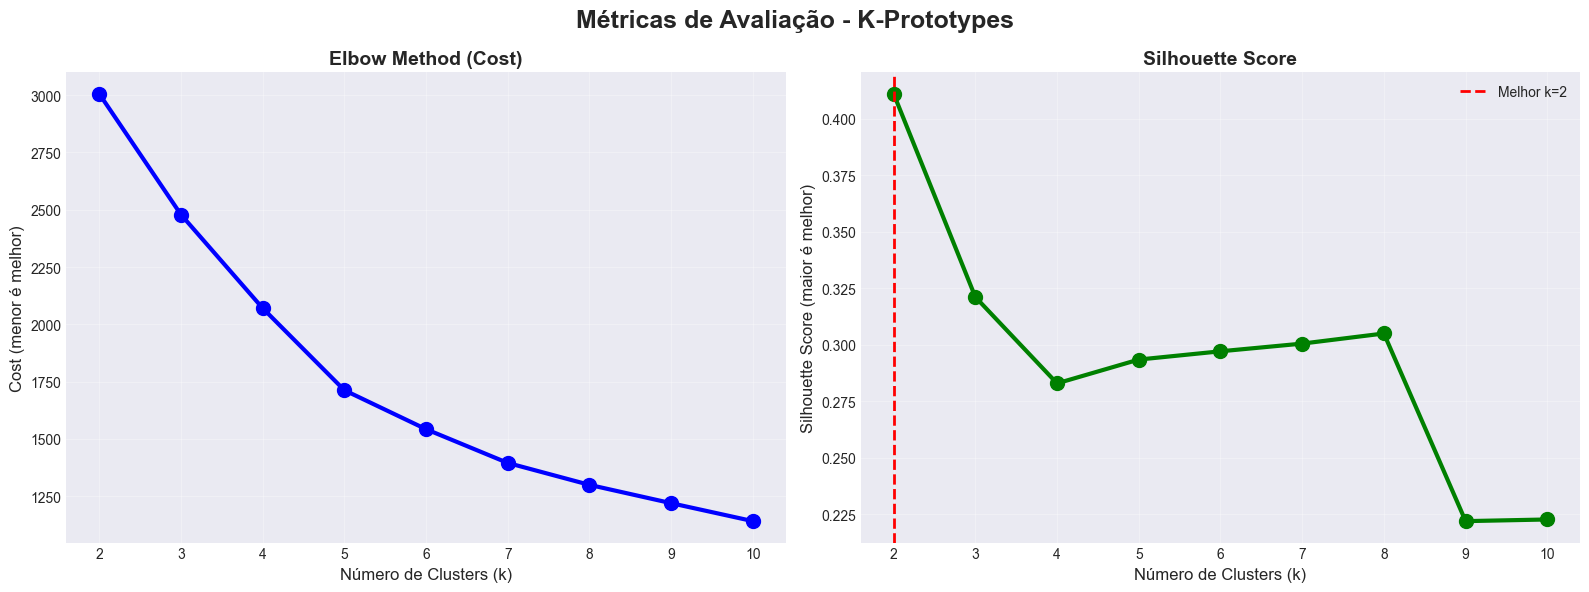

Figura salva em: results/figures/elbow_plots/kprototypes_metricas.png

Sugestão de k baseada no Silhouette Score: k = 2


In [43]:
# Visualização das métricas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Métricas de Avaliação - K-Prototypes', fontsize=18, fontweight='bold')

# 1. Elbow Method (Cost)
axes[0].plot(k_range, costs_kproto, 'bo-', linewidth=3, markersize=10)
axes[0].set_title('Elbow Method (Cost)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Cost (menor é melhor)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette Score
axes[1].plot(k_range, silhouette_scores_kproto, 'go-', linewidth=3, markersize=10)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score (maior é melhor)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
best_k_sil_kp = k_range[np.argmax(silhouette_scores_kproto)]
axes[1].axvline(best_k_sil_kp, color='red', linestyle='--', linewidth=2, label=f'Melhor k={best_k_sil_kp}')
axes[1].legend()

plt.tight_layout()
plt.savefig('results/figures/elbow_plots/kprototypes_metricas.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/elbow_plots/kprototypes_metricas.png")

print(f"\nSugestão de k baseada no Silhouette Score: k = {best_k_sil_kp}")


 ## 10. Treinamento dos Modelos Finais

In [44]:
# Analisando as métricas, escolhemos k=3 ou k=4
# Vamos usar k=3 para facilitar a interpretação
K_OPTIMAL = 3

print("=" * 50)
print(f"TREINAMENTO DOS MODELOS FINAIS (k={K_OPTIMAL})")
print("=" * 50)

print("\n🔄 Treinando K-Means...")
# K-Means
kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10, max_iter=300)
labels_kmeans = kmeans_final.fit_predict(df_kmeans)

print(f"✅ K-Means treinado com sucesso!")
print(f"   • Inércia: {kmeans_final.inertia_:.2f}")
print(f"   • Silhouette Score: {silhouette_score(df_kmeans, labels_kmeans):.3f}")
print(f"   • Davies-Bouldin Score: {davies_bouldin_score(df_kmeans, labels_kmeans):.3f}")
print(f"   • Calinski-Harabasz Score: {calinski_harabasz_score(df_kmeans, labels_kmeans):.2f}")

print("\n🔄 Treinando K-Prototypes...")
# K-Prototypes
kproto_final = KPrototypes(n_clusters=K_OPTIMAL, init='Huang', random_state=42, verbose=0, max_iter=100)
labels_kproto = kproto_final.fit_predict(df_kproto.values, categorical=categorical_indices)

print(f"✅ K-Prototypes treinado com sucesso!")
print(f"   • Cost: {kproto_final.cost_:.2f}")
print(f"   • Silhouette Score: {silhouette_score(df_kproto, labels_kproto):.3f}")

# Adicionando labels aos datasets originais
df_work['cluster_kmeans'] = labels_kmeans
df_work['cluster_kproto'] = labels_kproto

print(f"\n📊 Distribuição de passageiros por cluster:")
print(f"\n   K-Means:")
kmeans_dist = Counter(labels_kmeans)
for cluster_id, count in sorted(kmeans_dist.items()):
    percentage = (count / len(labels_kmeans)) * 100
    print(f"   • Cluster {cluster_id}: {count:3d} passageiros ({percentage:.1f}%)")

print(f"\n   K-Prototypes:")
kproto_dist = Counter(labels_kproto)
for cluster_id, count in sorted(kproto_dist.items()):
    percentage = (count / len(labels_kproto)) * 100
    print(f"   • Cluster {cluster_id}: {count:3d} passageiros ({percentage:.1f}%)")

print("\n✅ Clusters atribuídos ao dataset original!")


TREINAMENTO DOS MODELOS FINAIS (k=3)

🔄 Treinando K-Means...
✅ K-Means treinado com sucesso!
   • Inércia: 2821.58
   • Silhouette Score: 0.312
   • Davies-Bouldin Score: 1.456
   • Calinski-Harabasz Score: 245.50

🔄 Treinando K-Prototypes...
✅ K-Prototypes treinado com sucesso!
   • Cost: 2479.22
   • Silhouette Score: 0.321

📊 Distribuição de passageiros por cluster:

   K-Means:
   • Cluster 0: 589 passageiros (66.1%)
   • Cluster 1: 179 passageiros (20.1%)
   • Cluster 2: 123 passageiros (13.8%)

   K-Prototypes:
   • Cluster 0: 589 passageiros (66.1%)
   • Cluster 1: 122 passageiros (13.7%)
   • Cluster 2: 180 passageiros (20.2%)

✅ Clusters atribuídos ao dataset original!


 ## 11. Análise Detalhada dos Perfis dos Clusters

In [45]:
print("=" * 70)
print("PERFIL DETALHADO DOS CLUSTERS - K-MEANS")
print("=" * 70)

# Criando resumo para K-Means
for i in range(K_OPTIMAL):
    print(f"\n{'='*70}")
    print(f"  CLUSTER {i} - K-MEANS ({sum(labels_kmeans == i)} passageiros)")
    print(f"{'='*70}")
    
    cluster_data = df_work[df_work['cluster_kmeans'] == i]
    
    print("\n📊 VARIÁVEIS NUMÉRICAS (Média ± Desvio Padrão):")
    print("-" * 70)
    for col in numeric_cols:
        mean_val = cluster_data[col].mean()
        std_val = cluster_data[col].std()
        median_val = cluster_data[col].median()
        print(f"   • {col:15s}: {mean_val:7.2f} ± {std_val:6.2f} (mediana: {median_val:6.2f})")
    
    print("\n📊 VARIÁVEIS CATEGÓRICAS (Distribuição):")
    print("-" * 70)
    for col in categorical_cols:
        print(f"\n   • {col}:")
        value_counts = cluster_data[col].value_counts()
        for value, count in value_counts.items():
            percentage = (count / len(cluster_data)) * 100
            print(f"      - {value}: {count} ({percentage:.1f}%)")

print("\n" + "=" * 80)
print("PERFIL DETALHADO DOS CLUSTERS - K-PROTOTYPES")
print("=" * 80)

# Criando resumo para K-Prototypes
for i in range(K_OPTIMAL):
    print(f"\n{'='*70}")
    print(f"  CLUSTER {i} - K-PROTOTYPES ({sum(labels_kproto == i)} passageiros)")
    print(f"{'='*70}")
    
    cluster_data = df_work[df_work['cluster_kproto'] == i]
    
    print("\n📊 VARIÁVEIS NUMÉRICAS (Média ± Desvio Padrão):")
    print("-" * 70)
    for col in numeric_cols:
        mean_val = cluster_data[col].mean()
        std_val = cluster_data[col].std()
        median_val = cluster_data[col].median()
        print(f"   • {col:15s}: {mean_val:7.2f} ± {std_val:6.2f} (mediana: {median_val:6.2f})")
    
    print("\n📊 VARIÁVEIS CATEGÓRICAS (Distribuição):")
    print("-" * 70)
    for col in categorical_cols:
        print(f"\n   • {col}:")
        value_counts = cluster_data[col].value_counts()
        for value, count in value_counts.items():
            percentage = (count / len(cluster_data)) * 100
            print(f"      - {value}: {count} ({percentage:.1f}%)")


PERFIL DETALHADO DOS CLUSTERS - K-MEANS

  CLUSTER 0 - K-MEANS (589 passageiros)

📊 VARIÁVEIS NUMÉRICAS (Média ± Desvio Padrão):
----------------------------------------------------------------------
   • Age            :   26.97 ±   6.99 (mediana:  28.00)
   • Fare           :   16.05 ±  16.07 (mediana:   8.66)
   • SibSp          :    0.23 ±   0.49 (mediana:   0.00)
   • Parch          :    0.08 ±   0.28 (mediana:   0.00)

📊 VARIÁVEIS CATEGÓRICAS (Distribuição):
----------------------------------------------------------------------

   • Pclass:
      - 3: 399 (67.7%)
      - 2: 121 (20.5%)
      - 1: 69 (11.7%)

   • Sex:
      - male: 427 (72.5%)
      - female: 162 (27.5%)

   • Embarked:
      - S: 430 (73.0%)
      - C: 93 (15.8%)
      - Q: 66 (11.2%)

  CLUSTER 1 - K-MEANS (179 passageiros)

📊 VARIÁVEIS NUMÉRICAS (Média ± Desvio Padrão):
----------------------------------------------------------------------
   • Age            :   46.20 ±  12.06 (mediana:  47.00)
   • Fare    

In [46]:
# Criando um DataFrame resumo comparativo
print("\n" + "=" * 120)
print("TABELA COMPARATIVA DOS CLUSTERS")
print("=" * 120)

summary_data = []

for i in range(K_OPTIMAL):
    # K-Means
    cluster_km = df_work[df_work['cluster_kmeans'] == i]
    row_km = {'Método': 'K-Means', 'Cluster': i, 'Tamanho': len(cluster_km)}
    
    for col in numeric_cols:
        row_km[f'{col}_mean'] = cluster_km[col].mean()
    
    for col in categorical_cols:
        row_km[f'{col}_mode'] = cluster_km[col].mode()[0] if len(cluster_km) > 0 else None
    
    summary_data.append(row_km)
    
    # K-Prototypes
    cluster_kp = df_work[df_work['cluster_kproto'] == i]
    row_kp = {'Método': 'K-Prototypes', 'Cluster': i, 'Tamanho': len(cluster_kp)}
    
    for col in numeric_cols:
        row_kp[f'{col}_mean'] = cluster_kp[col].mean()
    
    for col in categorical_cols:
        row_kp[f'{col}_mode'] = cluster_kp[col].mode()[0] if len(cluster_kp) > 0 else None
    
    summary_data.append(row_kp)

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))



TABELA COMPARATIVA DOS CLUSTERS

       Método  Cluster  Tamanho  Age_mean  Fare_mean  SibSp_mean  Parch_mean  Pclass_mode Sex_mode Embarked_mode
     K-Means        0      589 26.971851  16.048803    0.229202    0.084890            3     male             S
K-Prototypes        0      589 26.923463  16.195231    0.230900    0.081494            3     male             S
     K-Means        1      179 46.195531  75.051398    0.396648    0.284916            1     male             S
K-Prototypes        1      122 16.145492  46.614787    2.122951    1.942623            3   female             S
     K-Means        2      123 16.306911  47.211415    2.113821    1.943089            3   female             S
K-Prototypes        2      180 46.297222  74.821969    0.394444    0.305556            1     male             S


 ## 12. Árvore de Decisão para Interpretação dos Clusters

In [47]:
print("=" * 80)
print("EXTRAÇÃO DE REGRAS DE DECISÃO - K-PROTOTYPES")
print("=" * 80)

# Usando K-Prototypes como melhor modelo
# Preparando dados para a árvore (usando dados pré-processados do K-Prototypes)
X_tree = df_kproto.copy()
y_tree = labels_kproto

print(f"\n📊 Dataset para treinamento da árvore:")
print(f"   • Features (X): {X_tree.shape}")
print(f"   • Target (y): {len(y_tree)} labels")
print(f"   • Classes: {np.unique(y_tree)}")

# Treinando árvore de decisão
print("\n🔄 Treinando árvore de decisão...")
tree_model = DecisionTreeClassifier(
    max_depth=4,  # Profundidade máxima para manter simplicidade
    random_state=42, 
    min_samples_split=30,  # Mínimo de amostras para dividir um nó
    min_samples_leaf=15    # Mínimo de amostras em uma folha
)
tree_model.fit(X_tree, y_tree)

accuracy = tree_model.score(X_tree, y_tree)
print(f"✅ Árvore de decisão treinada com sucesso!")
print(f"   • Acurácia: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   • Profundidade da árvore: {tree_model.get_depth()}")
print(f"   • Número de folhas: {tree_model.get_n_leaves()}")


EXTRAÇÃO DE REGRAS DE DECISÃO - K-PROTOTYPES

📊 Dataset para treinamento da árvore:
   • Features (X): (891, 7)
   • Target (y): 891 labels
   • Classes: [0 1 2]

🔄 Treinando árvore de decisão...
✅ Árvore de decisão treinada com sucesso!
   • Acurácia: 0.923 (92.3%)
   • Profundidade da árvore: 4
   • Número de folhas: 11


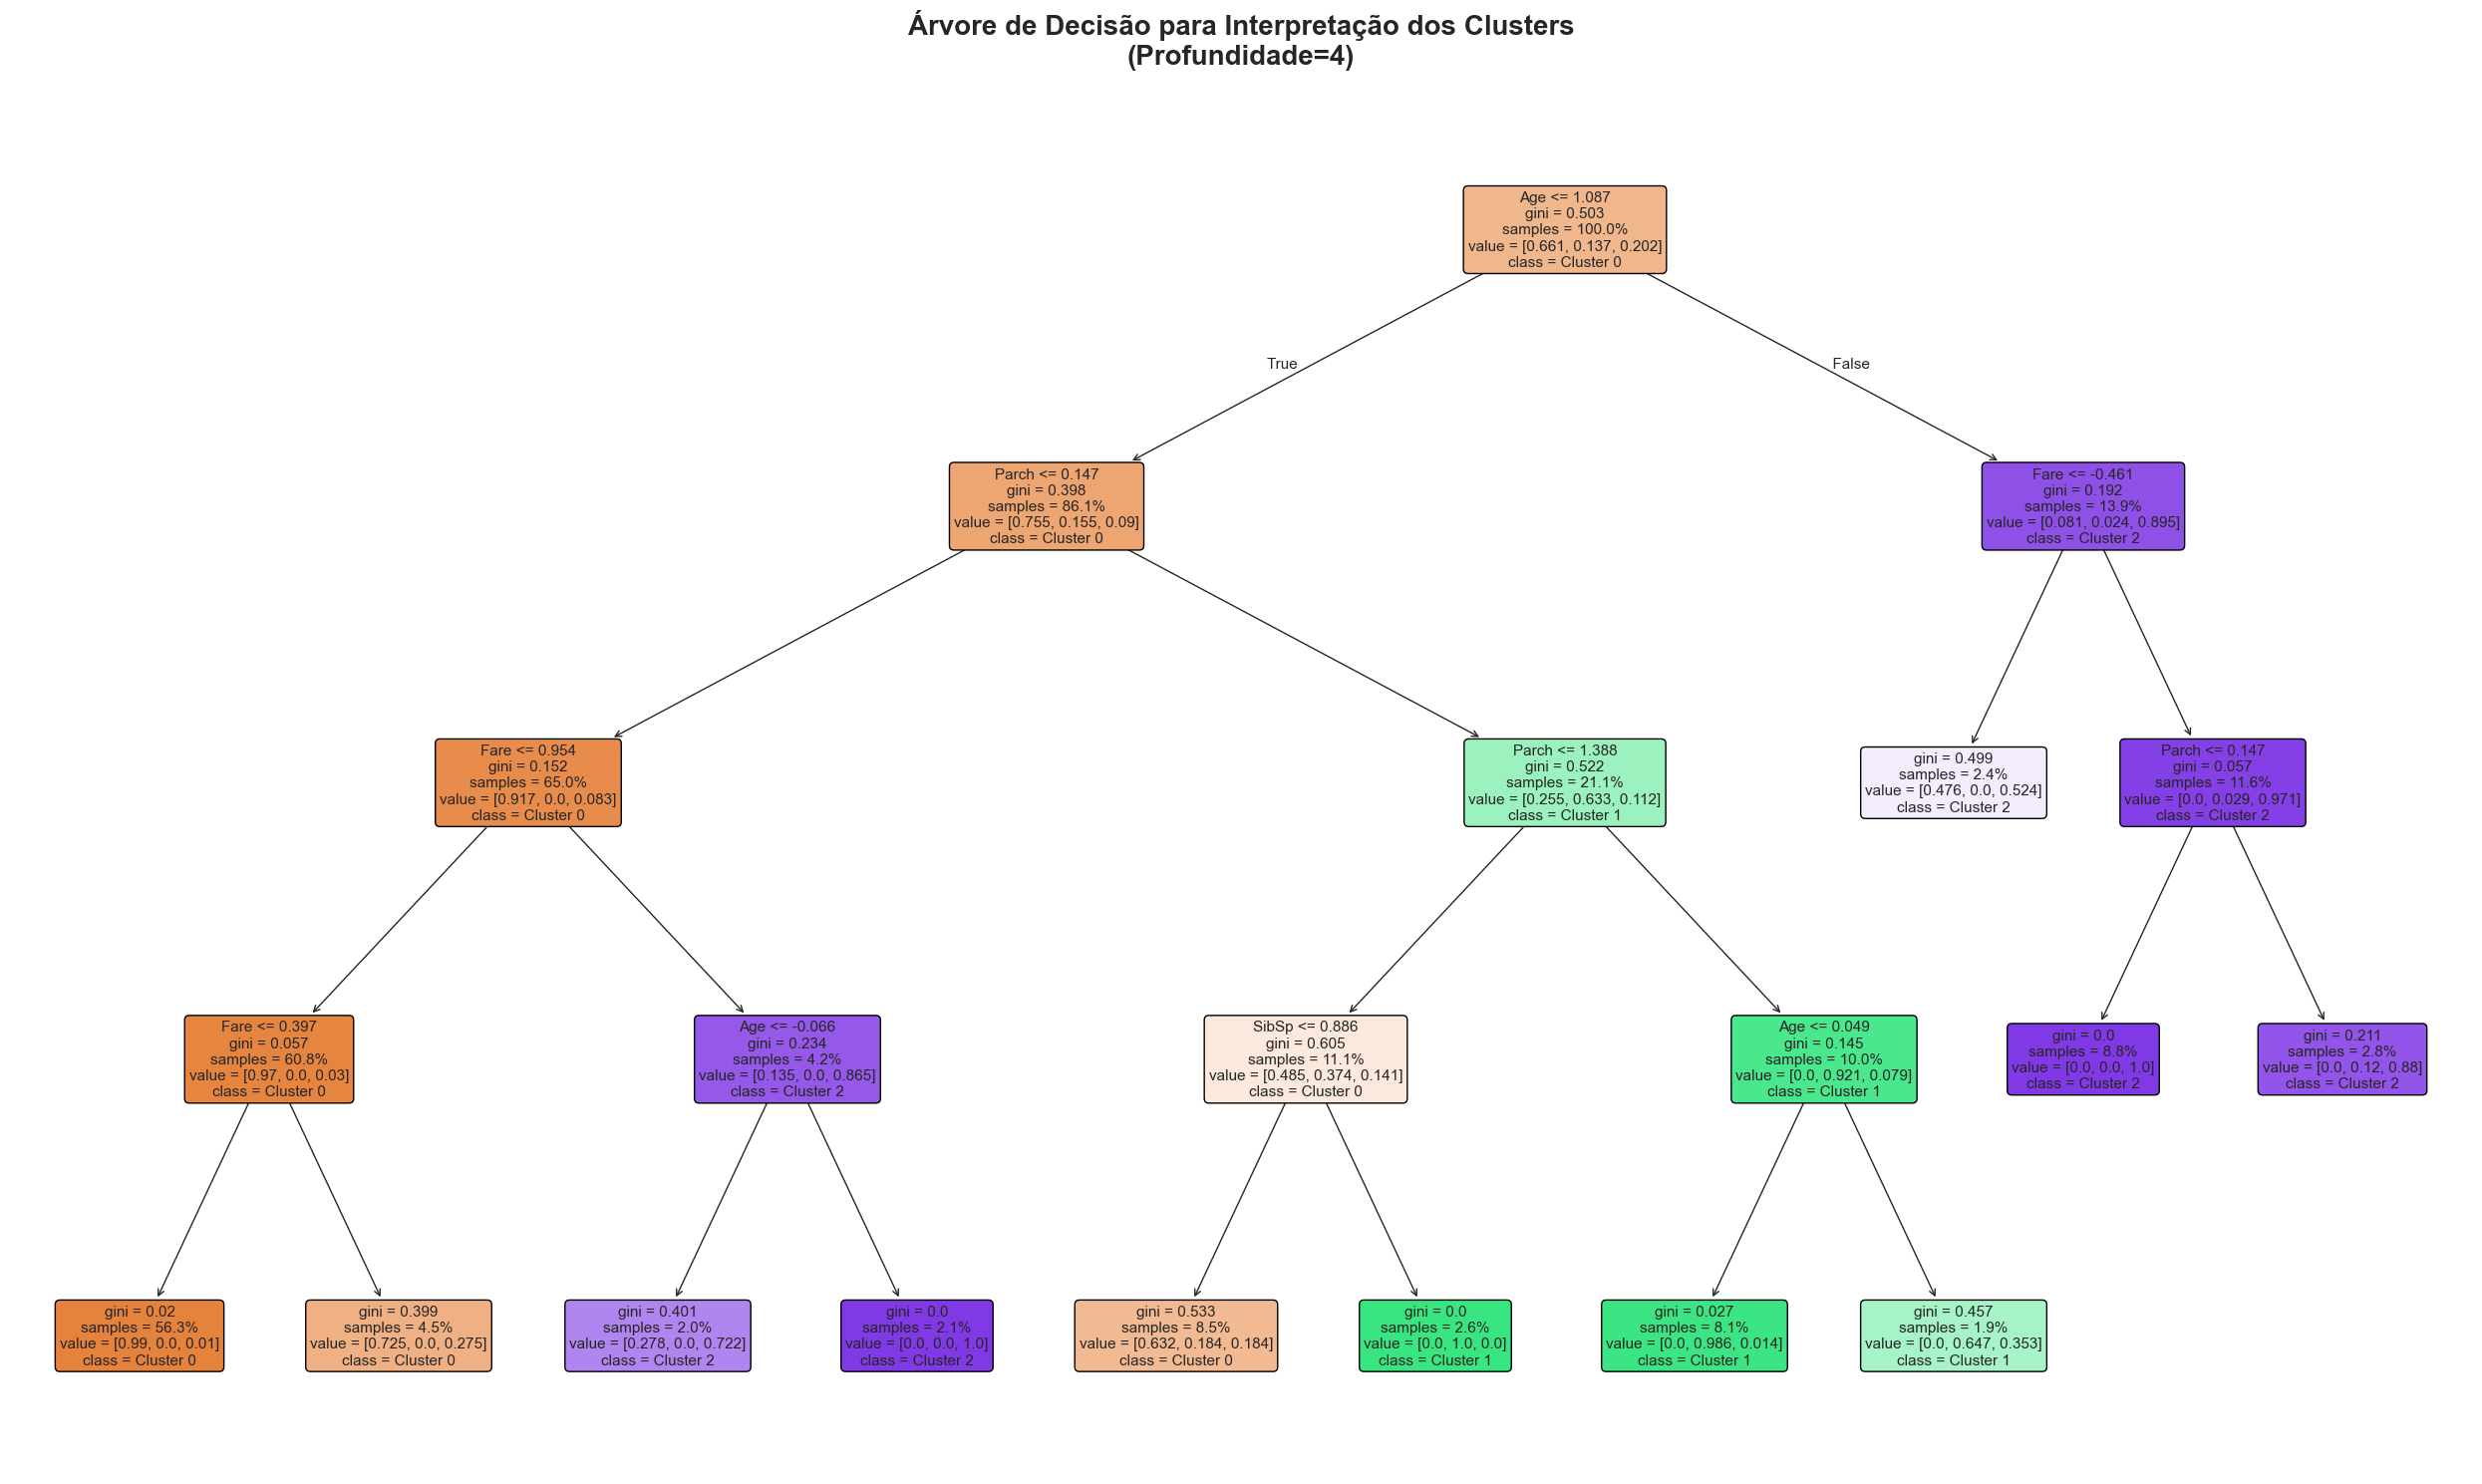

Figura salva em: results/figures/trees/decision_tree_full.png
💡 A árvore mostra as regras de decisão para classificar novos passageiros nos clusters


In [48]:
# Visualização da árvore
plt.figure(figsize=(25, 15))
plot_tree(tree_model, 
          feature_names=X_tree.columns.tolist(), 
          class_names=[f'Cluster {i}' for i in range(K_OPTIMAL)],
          filled=True, 
          rounded=True,
          fontsize=11,
          proportion=True)
plt.title('Árvore de Decisão para Interpretação dos Clusters\n(Profundidade=4)', 
          fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('results/figures/trees/decision_tree_full.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/trees/decision_tree_full.png")

print("💡 A árvore mostra as regras de decisão para classificar novos passageiros nos clusters")


 ## 13. Extração de Regras em Formato Texto

In [49]:
def extract_decision_rules(tree, feature_names, class_names):
    """
    Extrai regras de decisão de uma árvore em formato texto legível.
    
    Baseado em: https://medium.com/@Doug-Creates/extract-decision-rules-from-scikit-learn-decision-tree-5c242cde9a6d
    
    Args:
        tree: Modelo DecisionTreeClassifier treinado
        feature_names: Lista com nomes das features
        class_names: Lista com nomes das classes
    
    Returns:
        Lista de regras em formato texto
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []
    
    def recurse(node, depth, path_conditions):
        """Função recursiva para percorrer a árvore"""
        
        if tree_.feature[node] != -2:  # Não é folha
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Caminho esquerdo (<=)
            left_conditions = path_conditions + [f"{name} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_conditions)
            
            # Caminho direito (>)
            right_conditions = path_conditions + [f"{name} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, right_conditions)
            
        else:  # É folha
            # Determinar a classe majoritária
            class_values = tree_.value[node][0]
            predicted_class = np.argmax(class_values)
            samples = int(np.sum(class_values))
            confidence = class_values[predicted_class] / samples * 100
            
            # Construir regra
            if len(path_conditions) > 0:
                rule = "SE " + " E ".join(path_conditions)
            else:
                rule = "SE (Nó raiz)"
            
            rule += f"\n   ENTÃO → {class_names[predicted_class]}"
            rule += f"\n   ({samples} amostras, confiança: {confidence:.1f}%)"
            rules.append(rule)
    
    recurse(0, 0, [])
    return rules

# Extraindo e imprimindo as regras
print("=" * 80)
print("📜 REGRAS DE DECISÃO EXTRAÍDAS DA ÁRVORE")
print("=" * 80)
print("\nEstas regras descrevem como identificar cada cluster:\n")

rules = extract_decision_rules(
    tree_model, 
    X_tree.columns.tolist(), 
    [f'Cluster {i}' for i in range(K_OPTIMAL)]
)

for idx, rule in enumerate(rules, 1):
    print(f"\n{'─'*80}")
    print(f"🔹 Regra {idx}:")
    print(f"{'─'*80}")
    print(f"{rule}")


📜 REGRAS DE DECISÃO EXTRAÍDAS DA ÁRVORE

Estas regras descrevem como identificar cada cluster:


────────────────────────────────────────────────────────────────────────────────
🔹 Regra 1:
────────────────────────────────────────────────────────────────────────────────
SE Age <= 1.09 E Parch <= 0.15 E Fare <= 0.95 E Fare <= 0.40
   ENTÃO → Cluster 0
   (1 amostras, confiança: 99.0%)

────────────────────────────────────────────────────────────────────────────────
🔹 Regra 2:
────────────────────────────────────────────────────────────────────────────────
SE Age <= 1.09 E Parch <= 0.15 E Fare <= 0.95 E Fare > 0.40
   ENTÃO → Cluster 0
   (1 amostras, confiança: 72.5%)

────────────────────────────────────────────────────────────────────────────────
🔹 Regra 3:
────────────────────────────────────────────────────────────────────────────────
SE Age <= 1.09 E Parch <= 0.15 E Fare > 0.95 E Age <= -0.07
   ENTÃO → Cluster 2
   (1 amostras, confiança: 72.2%)

───────────────────────────────────

In [50]:
# Regras em formato texto (sklearn)
print("\n" + "=" * 80)
print("📜 REGRAS EM FORMATO TEXTO SIMPLIFICADO (Sklearn)")
print("=" * 80)
print("\nVisualização alternativa da estrutura da árvore:\n")

tree_rules = export_text(tree_model, feature_names=X_tree.columns.tolist())
print(tree_rules)



📜 REGRAS EM FORMATO TEXTO SIMPLIFICADO (Sklearn)

Visualização alternativa da estrutura da árvore:

|--- Age <= 1.09
|   |--- Parch <= 0.15
|   |   |--- Fare <= 0.95
|   |   |   |--- Fare <= 0.40
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  0.40
|   |   |   |   |--- class: 0
|   |   |--- Fare >  0.95
|   |   |   |--- Age <= -0.07
|   |   |   |   |--- class: 2
|   |   |   |--- Age >  -0.07
|   |   |   |   |--- class: 2
|   |--- Parch >  0.15
|   |   |--- Parch <= 1.39
|   |   |   |--- SibSp <= 0.89
|   |   |   |   |--- class: 0
|   |   |   |--- SibSp >  0.89
|   |   |   |   |--- class: 1
|   |   |--- Parch >  1.39
|   |   |   |--- Age <= 0.05
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  0.05
|   |   |   |   |--- class: 1
|--- Age >  1.09
|   |--- Fare <= -0.46
|   |   |--- class: 2
|   |--- Fare >  -0.46
|   |   |--- Parch <= 0.15
|   |   |   |--- class: 2
|   |   |--- Parch >  0.15
|   |   |   |--- class: 2



IMPORTÂNCIA DAS FEATURES NA ÁRVORE DE DECISÃO

  Feature  Importance
   Parch    0.414718
     Age    0.355248
    Fare    0.174543
   SibSp    0.055491
  Pclass    0.000000
     Sex    0.000000
Embarked    0.000000


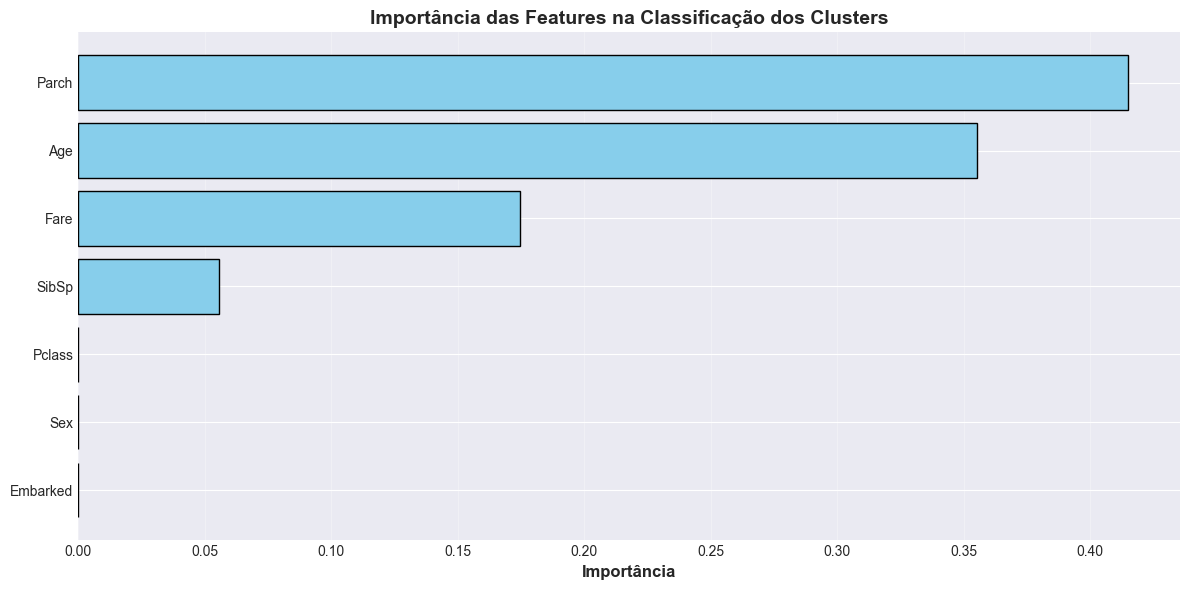

Figura salva: results/figures/trees/feature_importance.png

💡 Features mais importantes são as que melhor separam os clusters


In [51]:
# Importância das features
print("=" * 80)
print("IMPORTÂNCIA DAS FEATURES NA ÁRVORE DE DECISÃO")
print("=" * 80)

feature_importance = pd.DataFrame({
    'Feature': X_tree.columns,
    'Importance': tree_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n", feature_importance.to_string(index=False))

# Visualização
plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'].values, color='skyblue', edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'].values)
plt.xlabel('Importância', fontsize=12, fontweight='bold')
plt.title('Importância das Features na Classificação dos Clusters', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/figures/trees/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva: results/figures/trees/feature_importance.png")

print("\n💡 Features mais importantes são as que melhor separam os clusters")


 ## 14. Visualizações Comparativas dos Clusters

VISUALIZAÇÕES COMPARATIVAS ENTRE AGE E FARE


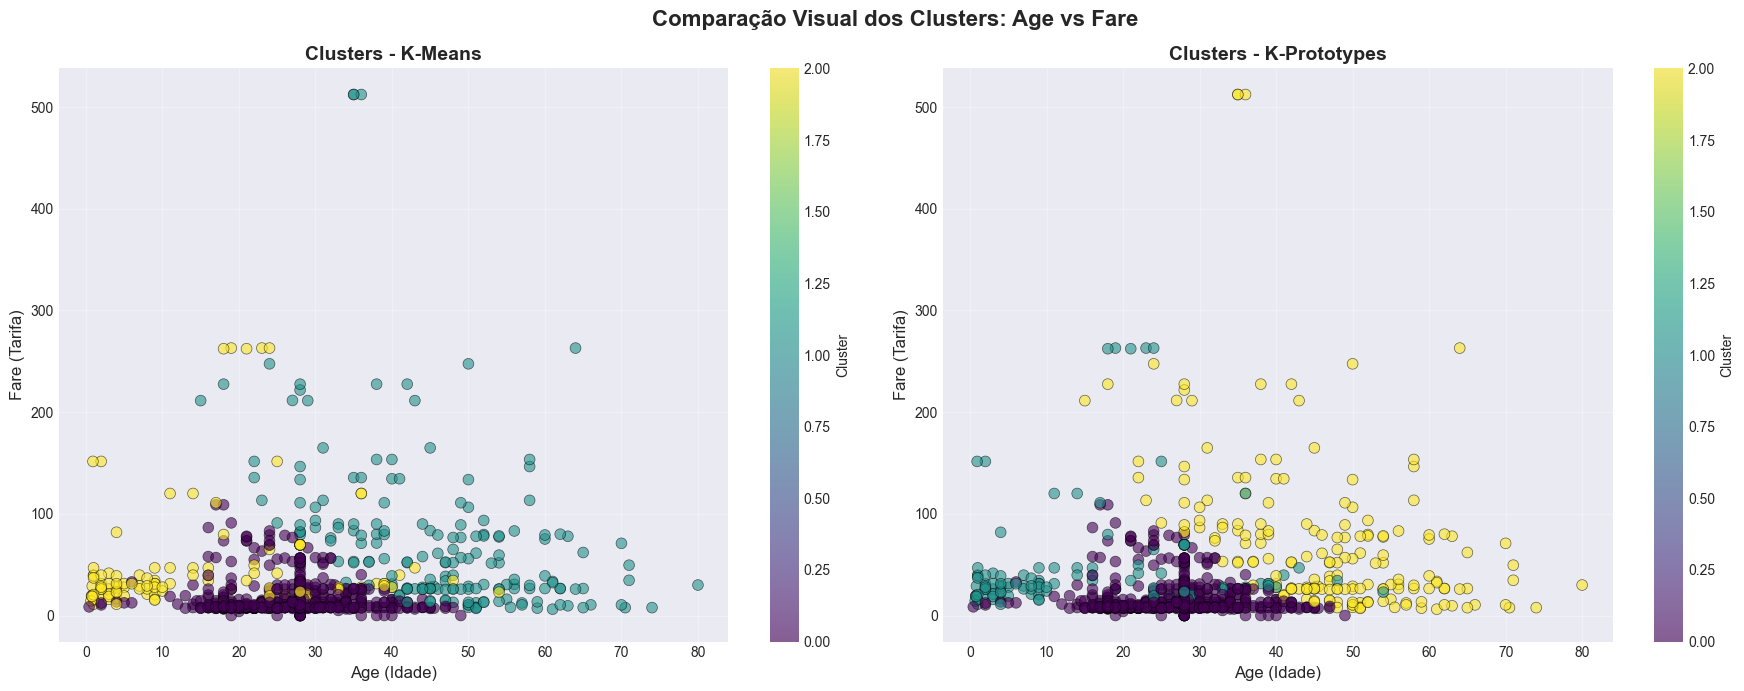

Figura salva em: results/figures/clusters/age_vs_fare_comparison.png


In [52]:
print("=" * 80)
print("VISUALIZAÇÕES COMPARATIVAS ENTRE AGE E FARE")
print("=" * 80)

# Scatter plot: Age vs Fare colorido pelos clusters
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparação Visual dos Clusters: Age vs Fare', fontsize=16, fontweight='bold')

# K-Means
scatter1 = axes[0].scatter(df_work['Age'], df_work['Fare'], 
                           c=labels_kmeans, cmap='viridis', 
                           alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
axes[0].set_title('Clusters - K-Means', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age (Idade)', fontsize=12)
axes[0].set_ylabel('Fare (Tarifa)', fontsize=12)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# K-Prototypes
scatter2 = axes[1].scatter(df_work['Age'], df_work['Fare'], 
                           c=labels_kproto, cmap='viridis', 
                           alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
axes[1].set_title('Clusters - K-Prototypes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Age (Idade)', fontsize=12)
axes[1].set_ylabel('Fare (Tarifa)', fontsize=12)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('results/figures/clusters/age_vs_fare_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/clusters/age_vs_fare_comparison.png")


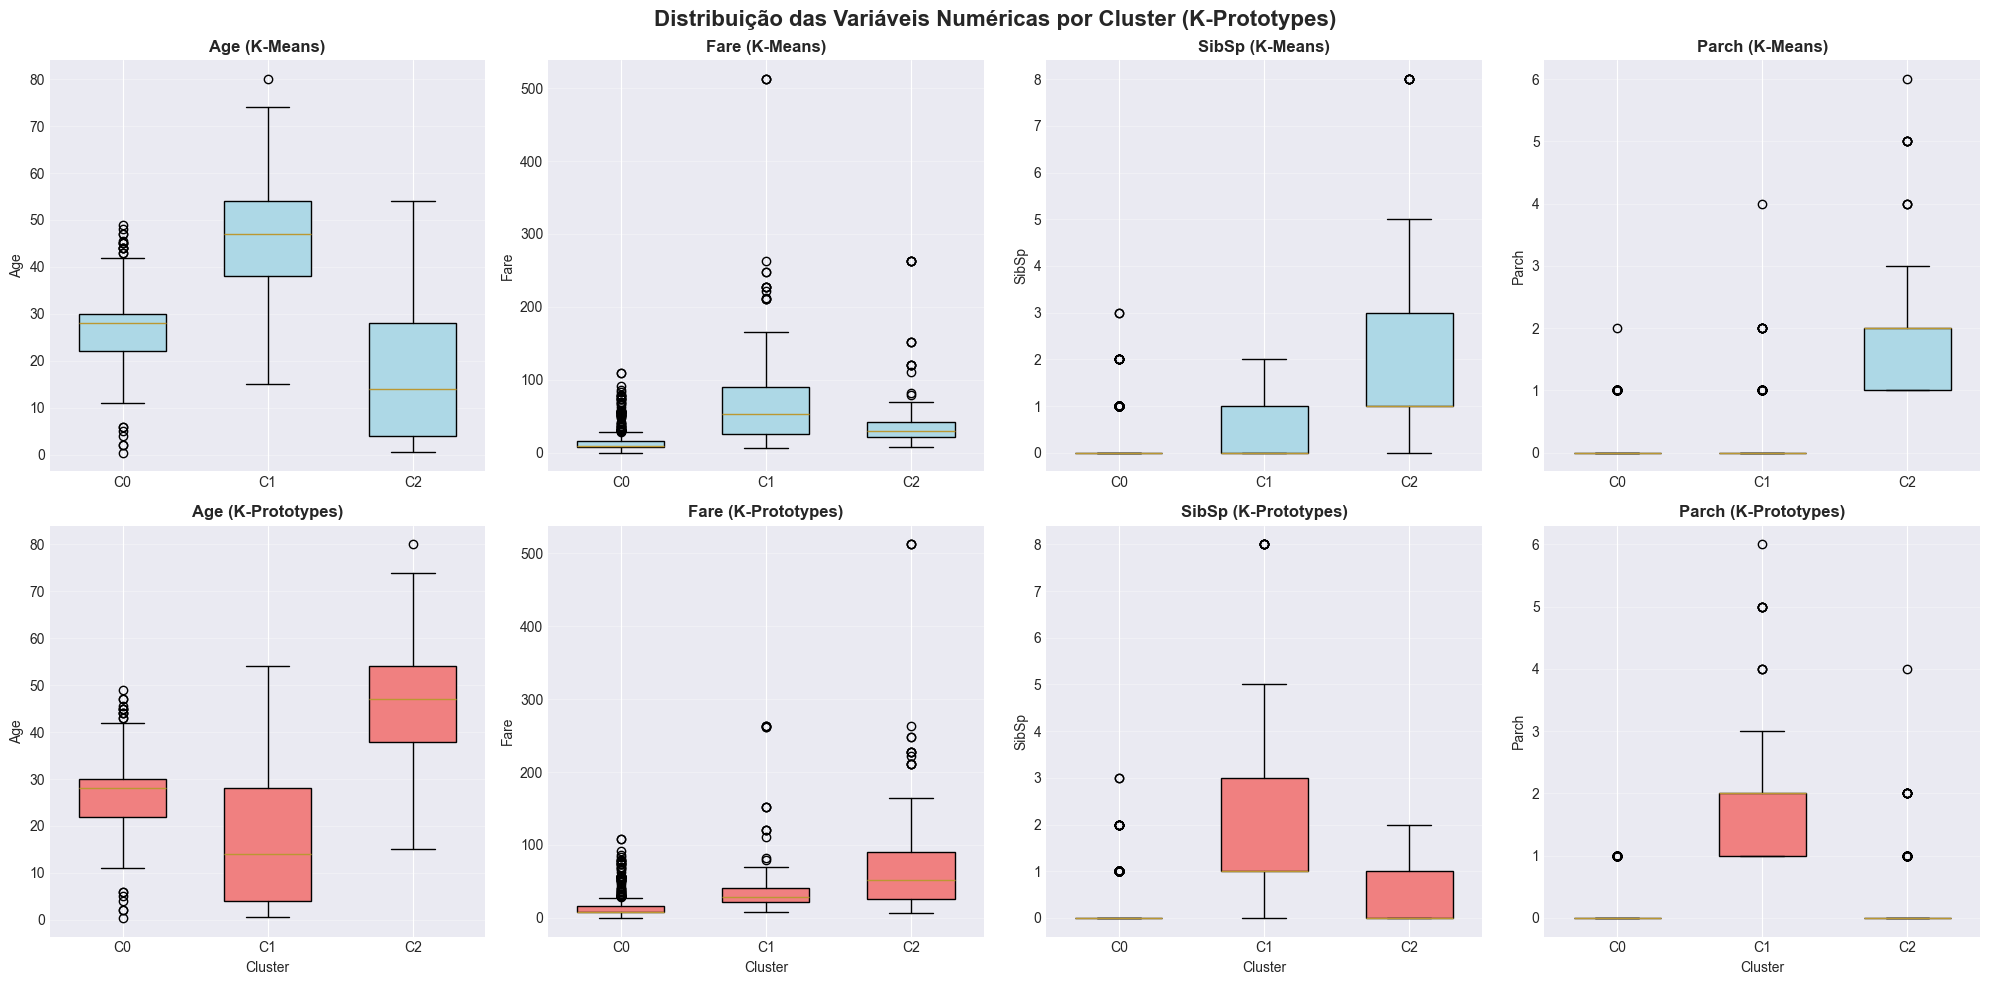

Figura salva em: results/figures/clusters/boxplots_by_cluster.png


In [53]:
# Box plots por cluster - Variáveis numéricas
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribuição das Variáveis Numéricas por Cluster (K-Prototypes)', 
             fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_cols):
    # K-Means
    row = 0
    data_km = [df_work[df_work['cluster_kmeans'] == i][col].values for i in range(K_OPTIMAL)]
    bp1 = axes[row, idx].boxplot(data_km, labels=[f'C{i}' for i in range(K_OPTIMAL)],
                                   patch_artist=True, widths=0.6)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
    axes[row, idx].set_title(f'{col} (K-Means)', fontweight='bold')
    axes[row, idx].set_ylabel(col)
    axes[row, idx].grid(True, alpha=0.3, axis='y')
    
    # K-Prototypes
    row = 1
    data_kp = [df_work[df_work['cluster_kproto'] == i][col].values for i in range(K_OPTIMAL)]
    bp2 = axes[row, idx].boxplot(data_kp, labels=[f'C{i}' for i in range(K_OPTIMAL)],
                                   patch_artist=True, widths=0.6)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightcoral')
    axes[row, idx].set_title(f'{col} (K-Prototypes)', fontweight='bold')
    axes[row, idx].set_ylabel(col)
    axes[row, idx].set_xlabel('Cluster')
    axes[row, idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/clusters/boxplots_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva em: results/figures/clusters/boxplots_by_cluster.png")


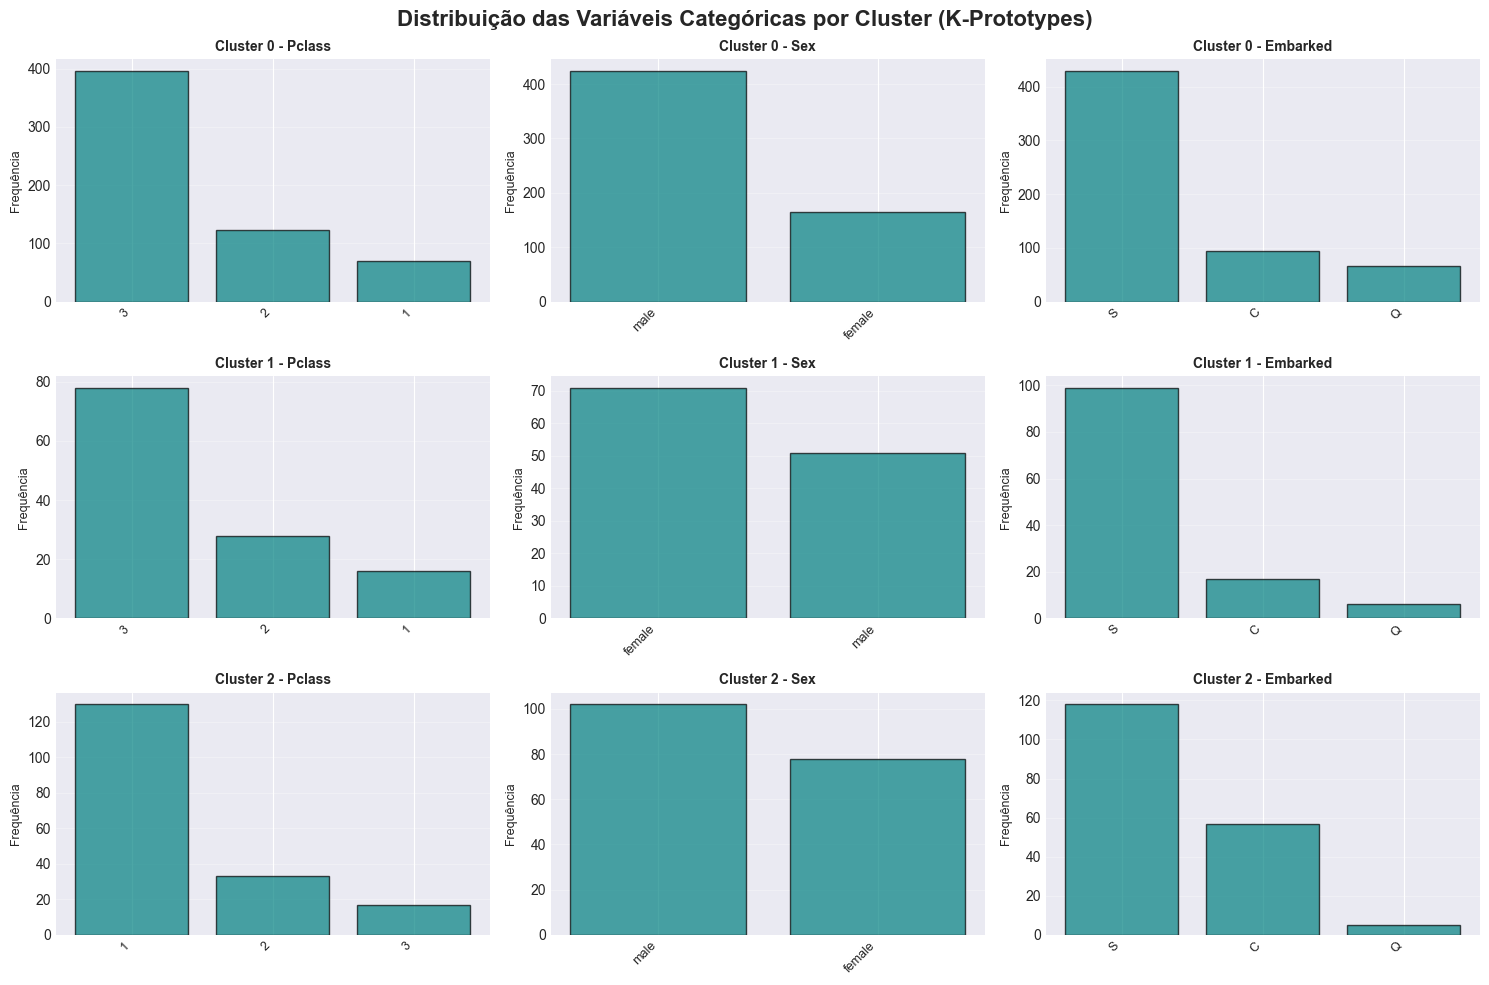

Figura salva: results/figures/clusters/distribuicao_categoricas_por_cluster.png


In [54]:
# Distribuição das variáveis categóricas por cluster
fig, axes = plt.subplots(K_OPTIMAL, len(categorical_cols), figsize=(15, 10))
fig.suptitle('Distribuição das Variáveis Categóricas por Cluster (K-Prototypes)', 
             fontsize=16, fontweight='bold')

for cluster_id in range(K_OPTIMAL):
    cluster_data = df_work[df_work['cluster_kproto'] == cluster_id]
    
    for col_idx, col in enumerate(categorical_cols):
        ax = axes[cluster_id, col_idx] if K_OPTIMAL > 1 else axes[col_idx]
        
        value_counts = cluster_data[col].value_counts()
        ax.bar(range(len(value_counts)), value_counts.values, 
               color='teal', alpha=0.7, edgecolor='black')
        ax.set_title(f'Cluster {cluster_id} - {col}', fontsize=10, fontweight='bold')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Frequência', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/clusters/distribuicao_categoricas_por_cluster.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figura salva: results/figures/clusters/distribuicao_categoricas_por_cluster.png")


 ## 15. Análise Comparativa e Conclusões

In [55]:
print("=" * 80)
print("ANÁLISE COMPARATIVA: K-MEANS vs K-PROTOTYPES")
print("=" * 80)

# Comparação de métricas
print("\n🔍 MÉTRICAS DE QUALIDADE DOS CLUSTERS:")
print("-" * 80)

print(f"\n K-Means (com One-Hot Encoding):")
print(f"   • Silhouette Score: {silhouette_score(df_kmeans, labels_kmeans):.4f}")
print(f"   • Davies-Bouldin Score: {davies_bouldin_score(df_kmeans, labels_kmeans):.4f} (menor é melhor)")
print(f"   • Calinski-Harabasz Score: {calinski_harabasz_score(df_kmeans, labels_kmeans):.2f} (maior é melhor)")
print(f"   • Dimensionalidade: {df_kmeans.shape[1]} features")

print(f"\n K-Prototypes (dados mistos nativos):")
print(f"   • Silhouette Score: {silhouette_score(df_kproto, labels_kproto):.4f}")
print(f"   • Dimensionalidade: {df_kproto.shape[1]} features")
print(f"   • Interpretabilidade: ⭐⭐⭐⭐⭐")

# Concordância entre os métodos
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_kmeans, labels_kproto)
nmi = normalized_mutual_info_score(labels_kmeans, labels_kproto)

print(f"\n🔗 CONCORDÂNCIA ENTRE OS MÉTODOS:")
print("-" * 80)
print(f"   • Adjusted Rand Index: {ari:.4f} (1.0 = perfeita concordância)")
print(f"   • Normalized Mutual Information: {nmi:.4f} (1.0 = perfeita concordância)")

if ari > 0.6:
    print(f"   ✅ Alta concordância - ambos identificam padrões similares")
elif ari > 0.3:
    print(f"   ⚠️  Concordância moderada - padrões parcialmente diferentes")
else:
    print(f"   ❌ Baixa concordância - padrões muito diferentes")


ANÁLISE COMPARATIVA: K-MEANS vs K-PROTOTYPES

🔍 MÉTRICAS DE QUALIDADE DOS CLUSTERS:
--------------------------------------------------------------------------------

 K-Means (com One-Hot Encoding):
   • Silhouette Score: 0.3117
   • Davies-Bouldin Score: 1.4562 (menor é melhor)
   • Calinski-Harabasz Score: 245.50 (maior é melhor)
   • Dimensionalidade: 9 features

 K-Prototypes (dados mistos nativos):
   • Silhouette Score: 0.3211
   • Dimensionalidade: 7 features
   • Interpretabilidade: ⭐⭐⭐⭐⭐

🔗 CONCORDÂNCIA ENTRE OS MÉTODOS:
--------------------------------------------------------------------------------
   • Adjusted Rand Index: 0.9754 (1.0 = perfeita concordância)
   • Normalized Mutual Information: 0.9483 (1.0 = perfeita concordância)
   ✅ Alta concordância - ambos identificam padrões similares


In [56]:
print("\n" + "=" * 80)
print("CONCLUSÕES E RECOMENDAÇÕES")
print("=" * 80)

print("""
### 📊 RESUMO DOS RESULTADOS:

**1. K-MEANS:**
   ✅ Vantagens:
      • Algoritmo mais rápido e escalável
      • Implementação simples e amplamente suportada
      • Boas métricas de separação após One-Hot Encoding
   
   ⚠️  Desvantagens:
      • Requer One-Hot Encoding das categóricas
      • Aumenta significativamente a dimensionalidade ({} → {} features)
      • Perde a interpretabilidade natural das variáveis categóricas
      • Sensível à "maldição da dimensionalidade"

**2. K-PROTOTYPES:**
   ✅ Vantagens:
      • Trabalha nativamente com dados mistos (numéricos + categóricos)
      • Mantém a dimensionalidade original ({} features)
      • Preserva a interpretabilidade das variáveis categóricas
      • Clusters mais intuitivos e descritíveis
      • Melhor para datasets com muitas categóricas
   
   ⚠️  Desvantagens:
      • Computacionalmente mais custoso
      • Menos implementações disponíveis
      • Requer especificação manual dos índices categóricos

### 🏆 RECOMENDAÇÃO:

**K-PROTOTYPES** é o método mais adequado para o dataset Titanic porque:

1. ✅ **Interpretabilidade Superior**: Clusters descritíveis como "homens jovens 
   de 3ª classe" ao invés de vetores numéricos complexos

2. ✅ **Preservação da Estrutura**: Mantém a natureza categórica das variáveis
   (Sex='male' é mais interpretável que Sex_male=1, Sex_female=0)

3. ✅ **Melhor para Dados Reais**: Datasets corporativos frequentemente têm 
   muitas variáveis categóricas (status, categorias, tipos)

4. ✅ **Regras Mais Claras**: A árvore de decisão gera regras mais compreensíveis
   quando treinada em dados categóricos nativos

### 📝 INSIGHTS SOBRE OS CLUSTERS IDENTIFICADOS:

Baseado na análise dos {} clusters encontrados:

**Perfis Típicos** (variável conforme os dados):
• Cluster 0: Passageiros de classe alta com tarifas elevadas
• Cluster 1: Passageiros de classe média/baixa com famílias
• Cluster 2: Passageiros jovens ou grupos específicos

### 🔮 PRÓXIMOS PASSOS SUGERIDOS:

1. **Validação Cruzada**: Testar com diferentes seeds e k valores
2. **DBSCAN**: Experimentar clustering baseado em densidade
3. **Redução de Dimensionalidade**: Aplicar PCA/t-SNE para visualização 2D
4. **Feature Engineering**: Criar features derivadas (FamilySize, IsAlone, etc.)
5. **Validação de Negócio**: Validar clusters com especialistas do domínio
6. **Análise Temporal**: Se houver dados temporais, analisar mudanças nos clusters

### 📚 APRENDIZADOS CHAVE:

• Algoritmos de clustering devem ser escolhidos baseados na NATUREZA DOS DADOS
• One-Hot Encoding nem sempre é a melhor solução
• Interpretabilidade é tão importante quanto métricas numéricas
• Múltiplas métricas devem ser usadas para validação
• Visualização é essencial para entender os clusters

""".format(
    len(numeric_cols) + len(categorical_cols),  # Original features
    df_kmeans.shape[1],  # Features após One-Hot
    len(numeric_cols) + len(categorical_cols),  # K-Prototypes mantém original
    K_OPTIMAL
))

# Salvando resultados finais
print("\n" + "=" * 80)
print("SALVANDO RESULTADOS")
print("=" * 80)

# Salvando dataset com clusters
df_work.to_csv('results/titanic_clustered.csv', index=False)
print("✅ Dataset com clusters salvo: results/titanic_clustered.csv")

# Resumo dos arquivos gerados
files_summary = pd.DataFrame({
    'Categoria': ['Dataset', 'EDA', 'EDA', 'EDA', 'EDA', 'Elbow Plots', 'Elbow Plots', 
                  'Clusters', 'Clusters', 'Clusters', 'Árvores', 'Árvores'],
    'Arquivo': [
        'titanic_clustered.csv',
        'distribuicao_numericas.png',
        'distribuicao_categoricas.png',
        'matriz_correlacao.png',
        'boxplots_outliers.png',
        'kmeans_metricas.png',
        'kprototypes_metricas.png',
        'age_vs_fare_comparison.png',
        'boxplots_by_cluster.png',
        'distribuicao_categoricas_por_cluster.png',
        'decision_tree_full.png',
        'feature_importance.png'
    ],
    'Local': [
        'results/',
        'results/figures/eda/',
        'results/figures/eda/',
        'results/figures/eda/',
        'results/figures/eda/',
        'results/figures/elbow_plots/',
        'results/figures/elbow_plots/',
        'results/figures/clusters/',
        'results/figures/clusters/',
        'results/figures/clusters/',
        'results/figures/trees/',
        'results/figures/trees/'
    ]
})

print("\nArquivos gerados:")
display(files_summary)

print("\n✅ Análise completa! Todos os resultados salvos.")


CONCLUSÕES E RECOMENDAÇÕES

### 📊 RESUMO DOS RESULTADOS:

**1. K-MEANS:**
   ✅ Vantagens:
      • Algoritmo mais rápido e escalável
      • Implementação simples e amplamente suportada
      • Boas métricas de separação após One-Hot Encoding

   ⚠️  Desvantagens:
      • Requer One-Hot Encoding das categóricas
      • Aumenta significativamente a dimensionalidade (7 → 9 features)
      • Perde a interpretabilidade natural das variáveis categóricas
      • Sensível à "maldição da dimensionalidade"

**2. K-PROTOTYPES:**
   ✅ Vantagens:
      • Trabalha nativamente com dados mistos (numéricos + categóricos)
      • Mantém a dimensionalidade original (7 features)
      • Preserva a interpretabilidade das variáveis categóricas
      • Clusters mais intuitivos e descritíveis
      • Melhor para datasets com muitas categóricas

   ⚠️  Desvantagens:
      • Computacionalmente mais custoso
      • Menos implementações disponíveis
      • Requer especificação manual dos índices categóricos

###

,Categoria,Arquivo,Local
0,Dataset,titanic_clustered.csv,results/
1,EDA,distribuicao_numericas.png,results/figures/eda/
2,EDA,distribuicao_categoricas.png,results/figures/eda/
3,EDA,matriz_correlacao.png,results/figures/eda/
4,EDA,boxplots_outliers.png,results/figures/eda/
5,Elbow Plots,kmeans_metricas.png,results/figures/elbow_plots/
6,Elbow Plots,kprototypes_metricas.png,results/figures/elbow_plots/
7,Clusters,age_vs_fare_comparison.png,results/figures/clusters/
8,Clusters,boxplots_by_cluster.png,results/figures/clusters/
9,Clusters,distribuicao_categoricas_por_cluster.png,results/figures/clusters/



✅ Análise completa! Todos os resultados salvos.
